In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import PCA as pca
import NN
%matplotlib inline

In [23]:
# Get PCA of simulated spectra
dir_ = "simulated_spectra/"   # data directory
pcs = 3                       # number of pca components
WL = (3924, 6662)             # single range

x, v, z, xs_hat, x_hat, wavelengths, ev = pca.do_PCA(dir_, WL, pcs, 1)

Successfully loaded files
3 PCs explain 0.997743 of the variance for wavelimits:. (3924, 6662)


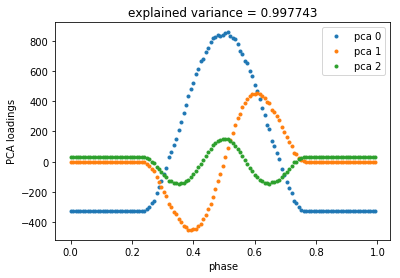

In [24]:
phases = np.load('files/phases.npy')

# cut index
#index = (phases > -0.25)&(phases < 0.25)
#z = z[index]
#phases = phases[index]

phases -= np.min(phases)
for i in range(pcs):
    plt.plot(phases, z[:,i], '.', label='pca %d'%i)
plt.ylabel('PCA loadings')
plt.xlabel('phase')
plt.title('explained variance = %f'%ev)
plt.legend()

In [25]:
# Prepare Data
n = len(z)

# indices
l = np.zeros(0)
p = np.zeros(0)
for i in range(pcs):
    l = np.concatenate((l, np.ones(n)*i))
    p = np.concatenate((p, phases))

# Data arrays
X = np.vstack((p,l)).T
Y = np.vstack((z.reshape(n*pcs), l)).T

In [32]:
# parameters
input_dim = 1
output_dim = pcs
Q = 2   #number of latent functions
R = 2   #rank of coreg matrix - number of latent functions that share the same covariance kernel k(x,x')

#standard kernels
#k = [gpflow.kernels.Cosine(input_dim, lengthscales=np.random.randn(input_dim)) for q in range(Q)]
k = [gpflow.kernels.Exponential(input_dim, lengthscales=np.random.randn(input_dim)) for q in range(Q)]
#k = [gpflow.kernels.RBF(input_dim, lengthscales=np.random.randn(input_dim)) for q in range(Q)]
# k = [gpflow.kernels.Exponential(input_dim, lengthscales=np.random.randn(input_dim)),
#      gpflow.kernels.Matern32(input_dim, lengthscales=np.random.randn(input_dim))]

#NN kernels
#nndim = [input_dim, 5, 5]
#k = [NN.NN_Exponential(NN.NN(nndim), input_dim, lengthscales=np.random.randn(input_dim)) for q in range(Q)]

#make LMC
coreg = [gpflow.kernels.Coregion(input_dim, output_dim=output_dim, rank=R, active_dims=[1]) for q in range(Q)]
kern = coreg[0] * k[0]
for q in range(1,Q):
    kern += coreg[q] * k[q]

lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT()]*output_dim) 
m = gpflow.models.SVGP(X, Y, kern=kern, likelihood=lik, num_latent=1, Z=X[::3].copy())
m.compile()

#randomize coregionalization matrix W for best results
if Q > 1:
    m.kern.prod_1.coregion.W = np.random.randn(output_dim, R)
    m.kern.prod_2.coregion.W = np.random.randn(output_dim, R)
else:
    m.kern.coregion.W = np.random.randn(output_dim, R)
    #m.kern.coregion.kappa = np.zeros(output_dim) #force kappa terms to be 0 and untrainable
    #m.kern.coregion.kappa.set_trainable(False)

In [33]:
gpflow.train.ScipyOptimizer().minimize(m, maxiter=2000)

/storage/work/ajs725/conda/install/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2596.084866
  Number of iterations: 235
  Number of functions evaluations: 399


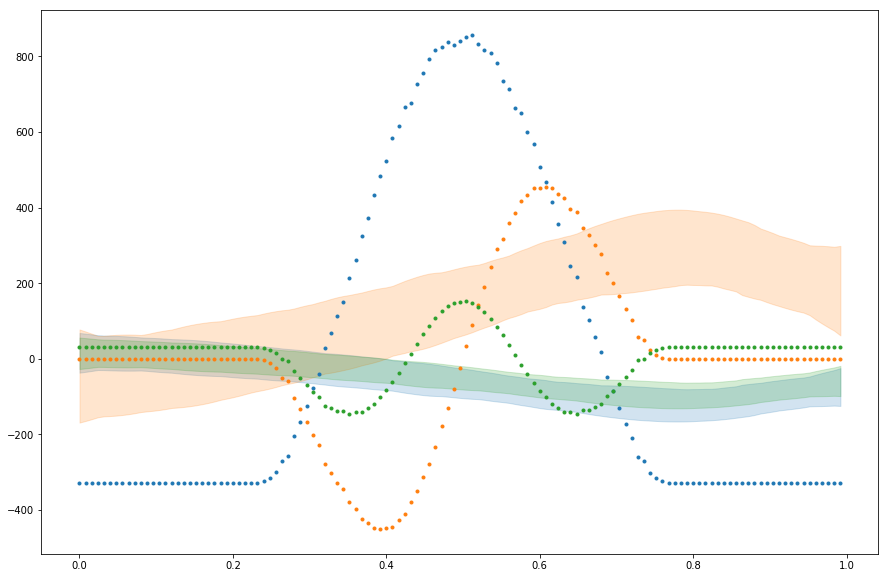

In [34]:
xtest = np.linspace(0, max(phases), n)[:,None]
plt.figure(figsize=(15,10))
for i in range(output_dim):
    line, = plt.plot(phases, z[:,i], '.')
    mu, var = m.predict_f(np.hstack((xtest, i+np.zeros_like(xtest))))
    #plt.plot(xtest, mu, color=line.get_color(), lw=2)
    mu, var = mu.reshape(n,), var.reshape(n,)
    plt.fill_between(xtest.reshape(n,), mu-2*np.sqrt(var), mu+2*np.sqrt(var), color=line.get_color(), alpha=0.2)

#plt.savefig("images/expK_pcs%d_Q%d_R%d.png"%(pcs,Q,R))

In [22]:
print(m)

<Parameter name:SVGP/kern/prod_1/coregion/W [trainable] shape:(3, 2) transform:(none) prior:None>
value: [[-12.84707796,  -2.95232146],
        [ 30.76446549,   1.10778266],
        [-26.9344789 ,  23.00711751]]

<Parameter name:SVGP/kern/prod_1/coregion/kappa [trainable] shape:(3,) transform:+ve prior:None>
value: [ 4.06507557,  3.10970313,  2.18930896]

<Parameter name:SVGP/kern/prod_1/exponential/variance [trainable] shape:() transform:+ve prior:None>
value: 27.842071384565887

<Parameter name:SVGP/kern/prod_1/exponential/lengthscales [trainable] shape:(1,) transform:+ve prior:None>
value: [ 0.42810915]

<Parameter name:SVGP/kern/prod_2/coregion/W [trainable] shape:(3, 2) transform:(none) prior:None>
value: [[ 18.28192853, -25.2460006 ],
        [-26.62294891,  43.69097115],
        [ -9.81043099,   8.3185437 ]]

<Parameter name:SVGP/kern/prod_2/coregion/kappa [trainable] shape:(3,) transform:+ve prior:None>
value: [ 4.26057547,  3.58924847,  2.55402879]

<Parameter name:SVGP/kern/p